In [3]:
import torch
from torch import nn
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import os

from game import BlackJack
from model import Blackjack_DQNet

In [4]:
# Create the directory to store the model
model_folder_path = "./model"
if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
MODEL_PATH = os.path.join(model_folder_path, "model.pth")

In [5]:
MAX_MEMORY = 1_000_000 # Memory for long term memory
BATCH_SIZE = 1000 # How many samples to take for long term memory
LR = 0.001

In [6]:
plt.ion()

def plot(scores:list[int], mean_scores:list[float]):
    """
    Contiuously plots the current score as well as the average score during training
    
    """
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.clf()
    plt.title("Training")
    plt.xlabel("Number of Games")
    plt.ylabel("Score")
    plt.plot(scores, label = "Total Score")
    plt.plot(mean_scores, label = "Average Score")
    plt.ylim(ymin = -800)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.legend()

In [7]:
class QTrainer:
    def __init__(self, model, learning_rate, gamma):
        self.lr = learning_rate
        self.gamma = gamma
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state:tuple, action:tuple, reward:tuple, next_state:tuple, done:tuple):
        """
        Updates the weights of the DQN model using the Bellman Equation (Q-loss)

        """
        state = torch.tensor(state, dtype = torch.float)
        next_state = torch.tensor(next_state, dtype = torch.float)
        action = torch.tensor(action, dtype= torch.float)
        reward = torch.tensor(reward, dtype = torch.float)

        if len(state.shape) == 1: # Add batch dimension if there is only 1 sample
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)
        
        pred = self.model(state)
        target = pred.clone()

        for i in range(len(done)):
            Q_new = reward[i]
            if not done[i]:
                Q_new = reward[i] + self.gamma * torch.max(self.model(next_state[i]))
            target[i][torch.argmax(action).item()] = Q_new

        # Q_new = r + y*max(next_predicted Q value) -> only do this if not done

        # preds[argmax(action)] = Q_new
        loss = self.criterion(target, pred)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # Parameters to control randomness
        self.gamma = 0.9 # Discount rate is less than 1
        self.memory = deque(maxlen = MAX_MEMORY) # popleft()
        self.model = Blackjack_DQNet(2,128,2) # 2 state values, 2 different actions, play around with hidden size
        self.trainer = QTrainer(self.model, learning_rate = LR, gamma = self.gamma)


    def get_state(self, game:BlackJack):
        """
        Gets the current game state i.e. player hand value and dealer upcard
        
        """
        return game.get_state()
        
    def remember(self, state:tuple, action:int, reward:int, next_state:tuple, done:bool):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        """
        Picks out a sample of BATCH_SIZE from the memory to use to calculate loss
        """
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # Returns a list of tuples 
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        
        self.trainer.train_step(states, actions, rewards, next_states, dones)
    
    def train_short_memory(self, state:tuple, action:int, reward:int, next_state:tuple, done:bool):
        """
        Trains the model using only the current state and previous state
        """
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state:tuple):
        """
        Use the DQN to predict the action to take i.e. Hit or Stand
        """
        # Random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0]
        if random.randint(0, 200) < self.epsilon: # Random actions 
            move = random.randint(0, 1)
            final_move[move] = 1
        else:
            state_0 = torch.tensor(state, dtype = torch.float)
            prediction = self.model(state_0) # Make an action
            move = torch.argmax(prediction).item() 
            final_move[move] = 1

        return final_move

In [9]:
def train():
    """
    The RL training loop 
    """
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    score = 0
    agent = Agent()
    num_decks = 1
    game = BlackJack(num_decks)
    while True:
        # Get old state
        state_old = agent.get_state(game)
        
        # Get move
        final_move = agent.get_action(state_old)
        
        action_list = ["Hit", "Stand"]
        action_move = action_list[np.argmax(final_move)]

        # Perform move and get new state
        state_new, reward, done = game.step(action_move)

        # Train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # Remember 
        agent.remember(state_old, final_move, reward, state_new, done)
        score += reward
        if done:
            # Train the long memory, plot results
            game.reset(num_decks)
            agent.n_games += 1
            agent.train_long_memory()
            

            if score > record:
                record = score
                torch.save(agent.model.state_dict(), MODEL_PATH) # Save best model

            print(f"Game {agent.n_games} | Score: {score} | Record {record}")

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores) # Continuous plotting

KeyboardInterrupt: 

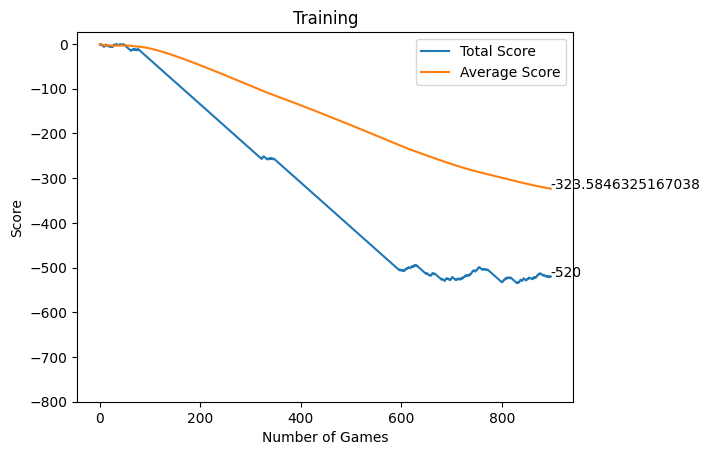

In [10]:
train()